# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим необходимые нам библиотеки и посмотрим на данные. 

In [19]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import nltk
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
stop_words = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dkiro\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv(r'C:\Users\dkiro\Desktop\проект\toxic_comments.csv')


In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим на соотношение токсичных и нормальных комментариев в датасете. 

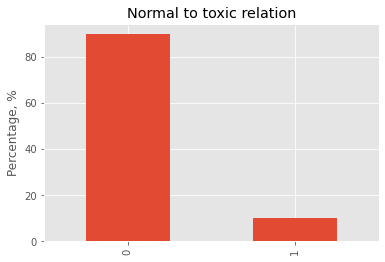

In [20]:
(df.toxic.value_counts(normalize = True) * 100).plot(kind = 'bar',
                                                     title = 'Normal to toxic relation');
plt.ylabel('Percentage, %', fontsize = 'large');

На диаграмме можно заметить, что токсичных комментариев в разы меньше, чем обычных. С точки зрения моделирования это не очень хорошо, поэтому будем учитывать этот момент подборе оптимальных моделей.

Очистим столбец с текстом от всего лишнего. Уберем все символы, кроме английских и затем лемматизируем их, убрав стоп-слова.

In [6]:
m = WordNetLemmatizer()

In [7]:
def clear_text(text):
    text = (re.sub(r'[^a-zA-Z]', ' ', text)).split(' ')
    text = ' '.join([word for word in text if word not in stop_words])
    text = ' '.join([m.lemmatize(word) for word in text.split()])
    return text

Применим функцию clear_text к столбцу *text*.

In [8]:
df['lemmed_text'] = df['text'].apply(clear_text)

In [9]:
df.head(8)

,text,toxic,lemmed_text
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why edits made username Hardcore M...
1,D'aww! He matches this background colour I'm s...,0,D aww He match background colour I seemingly s...
2,"Hey man, I'm really not trying to edit war. It...",0,Hey man I really trying edit war It guy consta...
3,"""\nMore\nI can't make any real suggestions on ...",0,More I make real suggestion improvement I wond...
4,"You, sir, are my hero. Any chance you remember...",0,You sir hero Any chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,Congratulations well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,Your vandalism to the Matt Shirvington article...,0,Your vandalism Matt Shirvington article revert...


In [10]:
df_train, df_val_test = train_test_split(df, test_size = 0.4,
                                         random_state = 123)

df_val, df_test = train_test_split(df_val_test, test_size = 0.5,
                                   random_state = 123)

In [11]:
X_train = df_train.lemmed_text.values # обучающая выборка 
y_train = df_train.toxic.values

X_val = df_val.lemmed_text.values # валидационная выборка
y_val = df_val.toxic.values

X_test = df_test.lemmed_text.values  # тестовая выборка 
y_test = df_test.toxic.values

## Обучение

Переведем тесты из твиттера в векторный формат с помощью TF-IDF меры. В этой модели вес некоторого слова пропорционален частоте употребления этого слова в документе и обратно пропорционален частоте употребления слова во всех документах коллекции

In [12]:
tf_idf = TfidfVectorizer(stop_words = stop_words)

In [13]:
train_tf_idf = tf_idf.fit_transform(X_train)
val_tf_idf = tf_idf.transform(X_val)
test_tf_idf = tf_idf.transform(X_test)

In [14]:
print('Размерность тренировочного набора данных:', train_tf_idf.shape)
print('Размерность валидационного набора данных:', val_tf_idf.shape)
print('Размерность тестового набора данных:', test_tf_idf.shape)


Размерность тренировочного набора данных: (95742, 121254)
Размерность валидационного набора данных: (31914, 121254)
Размерность тестового набора данных: (31915, 121254)


Обучим модель логистической регрессии на тренировочном корпусе и проверим качество модели на валидационной выборке. Модель с наибольшим F1_val будет считаться наилучшей. Зафиксируем max_iter = 300 и будем менять параметр C, отвечающий за регуляризацию регрессии. Поскольку классы у нас несбалансированные, поставим параметр class_weight='balanced'.

In [15]:
best_model_lg = None
best_f1 = 0

for c in np.linspace(1, 5, 10):
    model = LogisticRegression(max_iter=300,
                               C = c,
                               random_state=123,
                               class_weight='balanced')
    
    model.fit(train_tf_idf, y_train)
    predictions = model.predict(val_tf_idf)
    val_f1_score = f1_score(y_val, predictions)
    
    if val_f1_score > best_f1:
        best_f1 = val_f1_score
        best_model_lg = model
        
    print(f' С = {round(c, 2)} | F1_val = {round(val_f1_score, 4)}')
    
print('Лучшая модель логистической регрессии:', best_model_lg)

 С = 1.0 | F1_val = 0.7369
 С = 1.44 | F1_val = 0.7443
 С = 1.89 | F1_val = 0.7466
 С = 2.33 | F1_val = 0.7483
 С = 2.78 | F1_val = 0.7495
 С = 3.22 | F1_val = 0.7512
 С = 3.67 | F1_val = 0.7528
 С = 4.11 | F1_val = 0.7522
 С = 4.56 | F1_val = 0.7513
 С = 5.0 | F1_val = 0.7516
Лучшая модель логистической регрессии: LogisticRegression(C=3.6666666666666665, class_weight='balanced', max_iter=300,
                   random_state=123)


Можно заметить, что с ростом параметра C, значение метрики F1 также растет какое-то время. Однако после значения С=3.67, F1 на валидации падает. Соответственно, при значении C=3.67 F1 на валидации наибольший, это и будет оптимальная модель логистической регрессии.

Теперь аналогичным образом проверим работу алгоритма дерева решений на наших данных, только в этот раз будем менять глубину деревa и также, как и с логистичекой регрессией, поставим class_weight='balanced'.

In [16]:
best_model_dtr = None
best_f1 = 0

for depth in range(6, 26, 3):
    model = DecisionTreeClassifier(max_depth = depth,
                                   random_state=123,
                                   class_weight='balanced')
    
    model.fit(train_tf_idf, y_train)
    predictions = model.predict(val_tf_idf)
    val_f1_score = f1_score(y_val, predictions)
    
    if val_f1_score > best_f1:
        best_f1 = val_f1_score
        best_model_dtr = model
    print(f' max_depth = {depth} | F1_val = {round(val_f1_score, 4)}')
    
print('Лучшая модель дерева решений:',best_model_dtr )

 max_depth = 6 | F1_val = 0.4794
 max_depth = 9 | F1_val = 0.5409
 max_depth = 12 | F1_val = 0.5819
 max_depth = 15 | F1_val = 0.6092
 max_depth = 18 | F1_val = 0.5965
 max_depth = 21 | F1_val = 0.6134
 max_depth = 24 | F1_val = 0.6258
Лучшая модель дерева решений: DecisionTreeClassifier(class_weight='balanced', max_depth=24, random_state=123)


C увеличением максимальной глубины дерева F1 также растет. Однако значение метрики меньше, чем для логистической регрессии, соответственно, модель предсказывает классы твиттов хуже. Кроме того модель дольше обучается.

Проверим наконец модель градиентного бустинга. В качестве изменяющегося параметра возьмем learning_rate.

In [17]:
learning_rate_gb = [
    0.01, 0.1,
    0.5, 0.9
]

best_model_gb = None
best_f1 = 0

for rate in learning_rate_gb:
    model = lgb.LGBMClassifier(random_state = 123,
                               max_depth = 13,
                               learning_rate = rate,
                               class_weight = 'balanced')
    
    model.fit(train_tf_idf, y_train)
    predictions = model.predict(val_tf_idf)
    val_f1_score = f1_score(y_val, predictions)
    
    if val_f1_score > best_f1:
        best_f1 = val_f1_score
        best_model_gb = model
    print(f' learting_rate = {rate} | F1_val = {round(val_f1_score, 4)}')
    
print('Лучшая модель градиентного бустинга:', best_model_gb)

 learting_rate = 0.01 | F1_val = 0.6377
 learting_rate = 0.1 | F1_val = 0.723
 learting_rate = 0.5 | F1_val = 0.745
 learting_rate = 0.9 | F1_val = 0.7195
Лучшая модель градиентного бустинга: LGBMClassifier(class_weight='balanced', learning_rate=0.5, max_depth=13,
               random_state=123)


C ростом learning_rate значение метрики F1 также растет какое-то время. Однако после rate = 0.5, F1 на валидации падает. Соответственно, при значении rate = 0.5 F1 на валидации наибольший, это и будет оптимальная модель градиентного бустинга.

Сравним качество всех трех моделей с лучшими параметрами на тесте.

In [18]:
predict_lg = best_model_lg.predict(test_tf_idf)
test_f1_lg = f1_score(y_test, predict_lg)


predict_dtr = best_model_dtr.predict(test_tf_idf)
test_f1_dtr = f1_score(y_test, predict_dtr)


predict_gb = best_model_gb.predict(test_tf_idf)
test_f1_gb = f1_score(y_test, predict_gb)


print('F1_test_lg:', round(test_f1_lg, 3))
print('F1_test_dtr:', round(test_f1_dtr, 3))
print('F1_test_gb:', round(test_f1_gb, 3))


F1_test_lg: 0.763
F1_test_dtr: 0.609
F1_test_gb: 0.748


## Выводы

Мы очистили твитты от лишних символов и привели каждое слово твитта к исходной форме - лемме. Затем было проверено три модели с различными гипер параметрами: логистическая регрессия, дерево решений и градиентный бустинг. 

Лучшей моделью как по скорости, так и по качеству модели на тестовой выборке стала логистическая регрессия с параметрами max_iter=300 и С = 3.67. F1 на тестовой выборке составил 0.763, что больше 0.75. Значит, с поставленной задачей мы справились.